In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.nn.utils.parametrizations as parametrizations

print(torch.cuda.is_available())

import matplotlib.pyplot as plt
import numpy as np
import random

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

True


In [2]:
from framework import BaseCouplingLayer
from framework import BaseChunker
from framework import NormalizingFlow

In [3]:
# redo the GLOW implementation
class InvertibleConvolutionCouplingLayer(BaseCouplingLayer):
    def __init__(self, n_channels, eps = 1e-6):
        super(InvertibleConvolutionCouplingLayer, self).__init__()

        self.n_channels = n_channels
        W, _ = torch.linalg.qr(torch.randn(n_channels, n_channels))
        P, L, U = torch.linalg.lu(W)
        
        self.P = nn.Parameter(P, requires_grad=False)
        self.L = nn.Parameter(torch.tril(L, diagonal=-1), requires_grad=True)
        self.U = nn.Parameter(torch.triu(U, diagonal=1), requires_grad=True)
        
        self.L.register_hook(self._hook_L)
        self.U.register_hook(self._hook_U)

        self.s_vector = nn.Parameter(torch.diag(U), requires_grad=True)
        self.eps = eps

    def _hook_L(self, grad):
        # Mask gradient above the diagonal to 0
        mask = torch.tril(torch.ones_like(self.L), diagonal=-1)
        return grad * mask

    def _hook_U(self, grad):
        # Mask gradient below the diagonal to 0
        mask = torch.triu(torch.ones_like(self.U), diagonal=1)
        return grad * mask

    def forward(self, x):
        # Compute W
        s_sign = torch.sign(self.s_vector)
        W = (self.P @ (self.L + torch.eye(self.L.size(0)).to(x.device)) @ (self.U + torch.diag(self.s_vector + self.eps*s_sign))).unsqueeze(2).unsqueeze(3)
        
        # Apply convolution
        z = F.conv2d(x, W)
        
        # Compute log-determinant
        log_det_jacobian = torch.sum(torch.log(torch.abs(self.s_vector + self.eps*s_sign))).expand(x.shape[0]) * x.shape[2] * x.shape[3]

        return z, log_det_jacobian
    
    def inverse(self, z):
        # Compute W_inv W⁻¹ = (P L U)⁻¹ = U⁻¹ L⁻¹ P⁻¹
        
        s_sign = torch.sign(self.s_vector)
        W_inv = torch.linalg.inv(self.U + torch.diag(self.s_vector + s_sign * self.eps)) @ torch.linalg.inv(self.L + torch.eye(self.L.size(0)).to(self.L.device)) @ self.P.T
        W_inv = W_inv.unsqueeze(-1).unsqueeze(-1)
        # Apply inverse convolution
        x = F.conv2d(z, W_inv)
        return x
    
    def log_det_jacobian(self, x):
        s_sign = torch.sign(self.s_vector)
        return torch.sum(torch.log(torch.abs(self.s_vector + self.eps*s_sign))).expand(x.shape[0]) * x.shape[2] * x.shape[3]

In [4]:
# redo the GLOW implementation
class TempInvertibleConvolutionCouplingLayer(BaseCouplingLayer):
    def __init__(self, n_channels):
        super(InvertibleConvolutionCouplingLayer, self).__init__()

        self.n_channels = n_channels
        W, _ = torch.linalg.qr(torch.randn(n_channels, n_channels))
        
        self.W = nn.Parameter(W, requires_grad=False)

    def forward(self, x):
        
        # Apply convolution
        z = F.conv2d(x, self.W.unsqueeze(-1).unsqueeze(-1))
        
        # Compute log-determinant
        log_det_jacobian = torch.sum(torch.log(torch.abs(torch.linalg.det(self.W)))).expand(x.shape[0]) * x.shape[2] * x.shape[3]

        return z, log_det_jacobian
    
    def inverse(self, z):
        W_inv = torch.linalg.inv(self.W)
        x = F.conv2d(z, W_inv.unsqueeze(-1).unsqueeze(-1))
        return x
    
    def log_det_jacobian(self, x):
        log_det_jacobian = torch.sum(torch.log(torch.abs(torch.linalg.det(self.W)))).expand(x.shape[0]) * x.shape[2] * x.shape[3]
        return log_det_jacobian

In [5]:
class ActNormCouplingLayer(BaseCouplingLayer):
    def __init__(self, n_channels):
        super(ActNormCouplingLayer, self).__init__()

        self.n_channels = n_channels
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.forward_to_init = False
        
    def data_dependent_init(self, x):
        self.shift.data = -torch.mean(x, dim=(0, 2, 3)).view(1, self.n_channels, 1, 1)
        self.log_scale.data = -torch.log(torch.std(x, dim=(0, 2, 3), unbiased=False)).view(1, self.n_channels, 1, 1)

    def forward(self, x):
        if self.forward_to_init:
            self.forward_to_init = False
            self.data_dependent_init(x)
        
        # Apply activation normalization
        z = (x + self.shift) * torch.exp(self.log_scale)
        
        # Compute log-determinant
        log_det_jacobian = torch.sum(self.log_scale).expand(x.shape[0]) * x.shape[2] * x.shape[3]

        return z, log_det_jacobian
    
    def inverse(self, z):
        # Apply inverse activation normalization
        x = z * torch.exp(-self.log_scale) - self.shift
        return x
    
    def log_det_jacobian(self, x):
        return torch.sum(self.log_scale).expand(x.shape[0]) * x.shape[2] * x.shape[3]

In [6]:
from torchvision.datasets import CIFAR10

class DequantizeAndRescale:
    def __init__(self, noise_level=1/256, rescale_range=(0, 255), from_range=(0, 1)):
        self.noise_level = noise_level
        self.rescale_range = rescale_range
        self.from_range = from_range

    def __call__(self, x):
        x = x.to(torch.float32)
        noise = torch.rand_like(x) * self.noise_level
        x = x + noise
        
        min_val, max_val = self.rescale_range
        min_x, max_x = self.from_range
        x = (x - min_x) / (max_x - min_x)
        x = x * (max_val - min_val) + min_val
        x = x.clamp(min_val, max_val)
        return x


transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    DequantizeAndRescale(from_range=(0, 1), rescale_range=(0, 1-2/255)),
])

transforms_cifar_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms_cifar
])


# Download and load the CIFAR-10 training dataset
train_dataset = CIFAR10(root='../data', train=True, download=True, transform=transforms_cifar_train)

# Download and load the CIFAR-10 test dataset
test_dataset = CIFAR10(root='../data', train=False, download=True, transform=transforms_cifar)

batch_size = 128

# Create a DataLoader for the CIFAR-10 training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# make a grid of images nrow x nrow
def make_grid(images, nrow=8):
    images = images.detach().cpu()
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    return grid.permute(1, 2, 0)

def show(img):
    img = img.detach().cpu()
    plt.imshow(img)
    plt.axis('off')

def show_images(images, nrow=8):
    grid = make_grid(images, nrow)
    show(grid)

torch.Size([128, 3, 32, 32]) tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8,
        6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7,
        0, 1, 2, 3, 4, 6, 5, 9, 3, 5, 8, 8, 2, 6, 5, 0, 0, 2, 2, 0, 4, 4, 5, 2,
        8, 7, 4, 7, 2, 2, 0, 3])


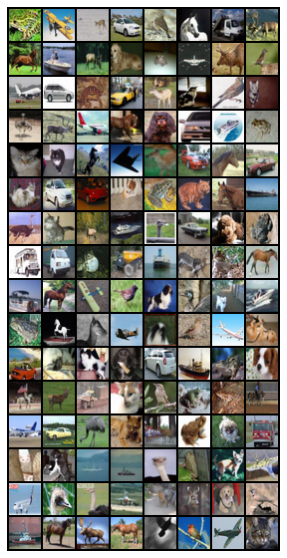

In [8]:
batch, classes = next(iter(train_loader))
print(batch.shape, classes)
plt.figure(figsize=(10, 10))
show_images(batch)

In [9]:
import abc

#for the future
class BaseConditionalCouplingLayer(BaseCouplingLayer, abc.ABC):
    def __init__(self):
        super(BaseCouplingLayer, self).__init__()
    
    @abc.abstractmethod
    def forward(self, x, c, *args, **kwargs):
        pass

    @abc.abstractmethod
    def inverse(self, y, c, *args, **kwargs):
        pass

    @abc.abstractmethod
    def log_det_jacobian(self, x, c, *args, **kwargs):
        pass

class ConditionalDistribution(torch.distributions.Distribution, abc.ABC):
    def __init__(self):
        super(ConditionalDistribution, self).__init__()

    @abc.abstractmethod
    def log_prob(self, x, c):
        pass

    @abc.abstractmethod
    def sample(self, c, sample_shape=torch.Size()):
        pass

class ConditionedLocFixedScale(ConditionalDistribution):
    def __init__(self, base_distribution, loc_model, scale):
        super(ConditionedLocFixedScale, self).__init__()
        self.base_distribution = base_distribution
        self.loc_model = loc_model  # The model that computes loc based on c
        self.scale = scale
    
    def log_prob(self, x, c):
        loc = self.loc_model(c).view(c.size(0), 1)
        dist = self.base_distribution(loc=loc, scale=self.scale)
        return dist.log_prob(x)

    def sample(self, c, sample_shape=torch.Size()):
        loc = self.loc_model(c)
        dist = self.base_distribution(loc=loc, scale=self.scale)
        batch_size = c.size(0)
        s = dist.sample(sample_shape)
        s = s.transpose(0, -1)
        return s
    
from torch.distributions import constraints

class ConditionedNormalFixedScale(ConditionedLocFixedScale):
    arg_constraints = {'scale': constraints.positive}
    def __init__(self, loc_model, scale):
        if isinstance(scale, (int, float)):
            scale = torch.tensor(scale) 
        self.scale = scale
        
        super(ConditionedNormalFixedScale, self).__init__(torch.distributions.Normal, loc_model, scale)

class ConditionalNormalizingFlow(NormalizingFlow):
    def __init__(self, layers, latent_dim, latent_distribution, device=None):
        super().__init__(layers, latent_dim, latent_distribution, device)

    def forward(self, x, c):
        log_det_jacobian = 0
        for layer in self.layers:
            if isinstance(layer, BaseConditionalCouplingLayer):
                x, ldj = layer(x, c)
            else:
                x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian
    
    def forward_log_prob(self, x, c):
        z, ldj = self.forward(x, c)
        if isinstance(self.latent_distribution, ConditionalDistribution):
            ldj += torch.sum(self.latent_distribution.log_prob(z, c), dim=-1)
        else:    
            ldj += torch.sum(self.latent_distribution.log_prob(z), dim=-1)
        return z, ldj

    def inverse(self, y, c):
        for layer in reversed(self.layers):
            if isinstance(layer, BaseConditionalCouplingLayer):
                y = layer.inverse(y, c)
            else:
                y = layer.inverse(y)
        return y

    def sample(self, n_samples, c):
        if isinstance(self.latent_distribution, ConditionalDistribution):
            z = self.latent_distribution.sample(c, (self.latent_dim,))
        else:
            z = self.latent_distribution.sample((n_samples, self.latent_dim))
        device = next(self.parameters()).device
        z = z.to(device)
        return self.inverse(z, c)

    def log_prob(self, x, c):
        _, lp = self.forward_log_prob(x, c)
        return lp


In [10]:
from framework import SequentialCouplingLayer, SqueezingCouplingLayer, AffineCouplingLayer, LogitCouplingLayer, SoftLogCouplingLayer
from framework import HalfChunker, ChannelWiseChunker

class GlowCouplingFunction(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super(GlowCouplingFunction, self).__init__()
        cf = nn.Sequential(nn.Conv2d(in_channels//2, hidden_dim, kernel_size=3, padding=1), nn.ReLU(),
                                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1), nn.ReLU(),
                                nn.Conv2d(hidden_dim, in_channels, kernel_size=3, padding=1))
        self.cf = cf
        with torch.no_grad():
            cf[4].weight.zero_()
            if cf[4].bias is not None:
                cf[4].bias.zero_()
        #self.scaling_factor = nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.scaling_factor = 1
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.cf(x)
        scale, shift = x.chunk(2, dim=1)
        
        scale = self.scaling_factor * self.tanh(scale)
        
        return torch.cat((scale, shift), dim=1)
    
class GlowBlockCouplingLayer(SequentialCouplingLayer):
    def __init__(self, n_channels, hidden_dim=512):
        invertible_conv = InvertibleConvolutionCouplingLayer(n_channels)
        act_norm = ActNormCouplingLayer(n_channels)

        cf = GlowCouplingFunction(n_channels, hidden_dim)
        
        affine_couplinglayer = AffineCouplingLayer(cf, ChannelWiseChunker(), should_mask=False)
        super(GlowBlockCouplingLayer, self).__init__([act_norm, invertible_conv, affine_couplinglayer])

class MultiScaleGlow(ConditionalNormalizingFlow):
    def __init__(self, in_size, in_channels, hidden_dim, L, K, latent_distribution, device=None, batch_norm=False):
        assert in_size % 2 == 0, "Input size must be divisible by 2"
                
        layers = []
        latent_dim = 0
        in_channels *= 4
        in_size //= 2
        for i in range(L - 1):
            layers.append(SequentialCouplingLayer([SqueezingCouplingLayer()] + [GlowBlockCouplingLayer(in_channels, hidden_dim) for _ in range(K)]))
            latent_dim += in_channels/2*in_size*in_size
            in_size //= 2
            in_channels *= 2 # Not 4 since we are going to split the channels in half to make the multi-scale architecture
        
        latent_dim += in_channels*in_size*in_size
        layers.append(SequentialCouplingLayer([SqueezingCouplingLayer()] + [GlowBlockCouplingLayer(in_channels, hidden_dim) for _ in range(K)]))
        self.z_initial_size = in_size
        self.z_initial_channels = in_channels
        print("LATENT DIM :", latent_dim)
        super().__init__(layers, int(latent_dim), latent_distribution, device)
        
        self.scl = LogitCouplingLayer()
        self.slcl = SoftLogCouplingLayer(tau=100)

    def forward_to_init(self, x, c):
        def set_forward_to_init(layer):
            if isinstance(layer, ActNormCouplingLayer):
                layer.forward_to_init = True
            elif hasattr(layer, 'children'):
                for sublayer in layer.children():
                    set_forward_to_init(sublayer)

        with torch.no_grad():
            for layer in self.layers:
                set_forward_to_init(layer)
            self(x, c)
        
    def forward(self, x, c):
        # Here we do the multi-scale architecture
        batch_size = x.size(0)
        z = []
        log_det_jacobian = torch.zeros(batch_size, device=x.device)
        x, ldj = self.scl(x)
        log_det_jacobian += ldj
        for layer in self.layers[:-1]:
            x, ldj = layer(x)
            log_det_jacobian += ldj
            z1, z2 = x.chunk(2, dim=1)
            x = z2
            z.append(z1.view(batch_size, -1))
            
        z_f, ldj = self.layers[-1](x)
        log_det_jacobian += ldj
        z.append(z_f.view(batch_size, -1))

        z = torch.cat(z, dim=1)
        z, ldj = self.slcl(z)
        log_det_jacobian += ldj
        return z, log_det_jacobian
    
    def inverse(self, z, c):
        batch_size = z.size(0)
        
        z = self.slcl.inverse(z)
        
        channels = self.z_initial_channels
        size = self.z_initial_size
        z_list = []
        
        for i in range(len(self.layers)):
            z_list.append(z[:, -channels*size*size:].view(batch_size, channels, size, size))
            z = z[:, :-channels*size*size]
            if i == 0:
                channels //= 2
            channels //= 2
            size *= 2
        
        h_L = self.layers[-1].inverse(z_list[0])
        for i, layer in enumerate(reversed(self.layers[:-1])):
            z_i = torch.cat((z_list[i+1], h_L),dim=1)
            h_L = layer.inverse(z_i)
        
        return self.scl.inverse(h_L)

In [11]:
n_classes = 10
latent_dim = 1

class SmallEmbeddingModel(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super().__init__()
        self.e = nn.Embedding(n_classes, n_classes)
        self.l = nn.Linear(n_classes, latent_dim)
    
    def forward(self, x):
        return self.l(self.e(x)).squeeze(-1)

smem = SmallEmbeddingModel(n_classes, latent_dim)
ld = ConditionedNormalFixedScale(smem, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = MultiScaleGlow(32, 3, 512, 3, 32, ld, device)
ld.scale = ld.scale.to(device)
ld.loc_model = ld.loc_model.to(device)

cuda
LATENT DIM : 3072.0


cuda cuda:0
torch.Size([128, 3, 32, 32]) torch.Size([128])
torch.Size([128, 3072])
torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


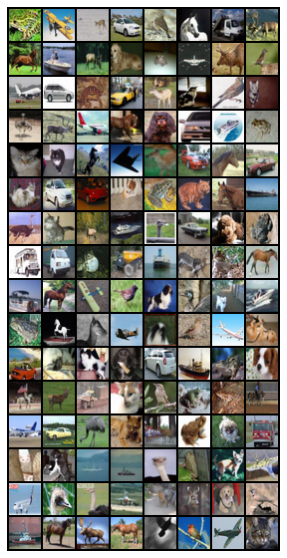

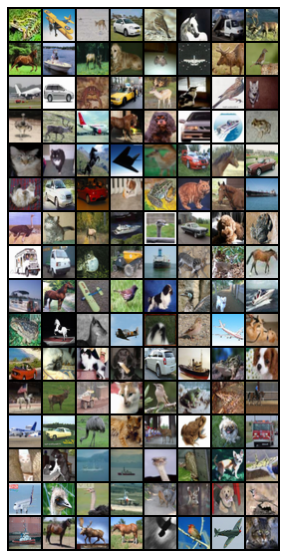

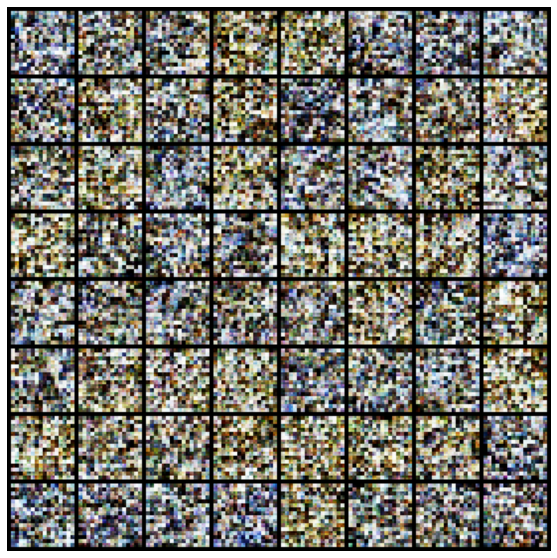

In [12]:
batch = batch.to(device)
classes = classes.to(device)
print(model.device, batch.device)
print(batch.shape, classes.shape)
with torch.no_grad():
    model.forward_to_init(batch, classes)

    z_batch, ldj = model(batch, classes)
    print(z_batch.shape)
    x_hat = model.inverse(z_batch, classes)
    print(x_hat.shape)

    plt.figure(figsize=(10, 10))
    show_images(batch)

    plt.figure(figsize=(10, 10))
    show_images(x_hat)

    samples = model.sample(64, classes[:64])
    plt.figure(figsize=(10, 10))
    show_images(samples)

In [13]:
# Define early stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Model saving path
best_model_path = 'cond_cifar_best_model.pth'
smem_model_path = 'cond_cifar_best_model_smem.pth'

# Training parameters
class SmallClassifier(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(dim, n_classes)
        self.sftmax = nn.Softmax()
    
    def forward(self, x):
        return self.sftmax(self.linear(self.flatten(x)))

    
classifier = SmallClassifier(12*8*8).to(device)
optimizer = torch.optim.Adam(    list(model.parameters()) + list(classifier.parameters()) + list(smem.parameters()), lr=5e-4)
h_lambda = 0.01
classification_criterion = nn.CrossEntropyLoss()
n_epochs = 0 # TO CHANGE IF WE WANT TO TRAIN AGAIN !

# Store losses to plot
train_losses = []
val_losses = []

# TensorBoard Summary Writer
writer = SummaryWriter(log_dir='runs/cond_cifar')
s = 0

def plot_generated_samples(samples, epoch):
    samples = samples.permute(0, 2, 3, 1).cpu().numpy()
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow((samples[i] - samples[i].min()) / (samples[i].max() - samples[i].min()))
        ax.axis('off')
    plt.suptitle(f'Generated Samples at Epoch {epoch}')
    plt.show()

for epoch in range(n_epochs):
    if early_stop:
        print("Early stopping triggered. Training stopped.")
        break
    
    batch_losses = []

    # Training phase
    model.train()
    for i, (batch_samples, classes) in enumerate(train_loader):
        print(f"{i}/{len(train_loader)}", end='\r')
        batch_samples = batch_samples.to(device)
        classes = classes.to(device)

        # Forward pass
        z, log_prob = model.forward_log_prob(batch_samples, classes)
        loss = -torch.mean(log_prob)  # Maximum likelihood estimation

        z_batch_size = z.size(0)
        
        z_sl = model.slcl.inverse(z)
        channels = model.z_initial_channels
        size = model.z_initial_size
        h_L = model.layers[-1].inverse(z[:, -channels*size*size:].view(z_batch_size, channels, size, size))
        z_sl = h_L
        pred = classifier(z_sl)
        classification_loss = classification_criterion(pred, classes)
        
        loss += h_lambda * classification_loss
        
        
        # Log Z statistics
        z_stats = {
            'z_max': z.max().item(),
            'z_min': z.min().item(),
            'z_mean': z.mean().item(),
            'z_std': z.std().item(),
            'z_percent_nan': torch.isnan(z).sum().item() / z.numel(),
            'classification_loss': classification_loss.mean().item()
        }

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        writer.add_scalar('Loss/train_b', loss.item(), s)

        # Log Z statistics to TensorBoard
        for stat_name, value in z_stats.items():
            writer.add_scalar(f'Statistics/{stat_name}', value, s)

        # Intermediate logging and plotting
        if s % (len(train_loader) // 2) == 0:
            model.eval()
            with torch.no_grad():
                classes = torch.arange(n_classes).repeat((batch_size + n_classes - 1) // n_classes)[:batch_size].to(device)
                learned_samples = model.sample(batch_size, classes).cpu()
                writer.add_images('b/Generated Samples', learned_samples, s)

                # Log X statistics
                x_stats = {
                    'x_max': learned_samples.max().item(),
                    'x_min': learned_samples.min().item(),
                    'x_mean': learned_samples.mean().item(),
                    'x_std': learned_samples.std().item(),
                    'x_percent_nan': torch.isnan(learned_samples).sum().item() / learned_samples.numel(),
                    'x_percent_pos_inf': torch.isinf(learned_samples).sum().item() / learned_samples.numel() - torch.isneginf(learned_samples).sum().item() / learned_samples.numel(),
                    'x_percent_neg_inf': torch.isneginf(learned_samples).sum().item() / learned_samples.numel()
                }

                for stat_name, value in x_stats.items():
                    writer.add_scalar(f'Statistics/{stat_name}', value, s)

            model.train()

        s += 1

    # Validation phase
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for val_samples, classes in val_loader:
            val_samples = val_samples.to(device)
            classes = classes.to(device)
            val_loss = -torch.mean(model.log_prob(val_samples, classes))
            batch_val_losses.append(val_loss.item())

        avg_train_loss = np.mean(batch_losses)
        avg_val_loss = np.mean(batch_val_losses)
        
        print(f"Epoch {epoch} - Training loss: {avg_train_loss:.4f} - Validation loss: {avg_val_loss:.4f}")

        # TensorBoard Logging
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)

        # Append losses for plotting
        val_losses.append(avg_val_loss)
        train_losses.append(avg_train_loss)

    # Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        torch.save(smem.state_dict(), smem_model_path)
        print(f"Best model saved at epoch {epoch} with validation loss: {avg_val_loss:.4f}")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch} - No improvement for {epochs_no_improve} epochs.")

    # Early stopping
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        early_stop = True

# Close the writer after training
writer.close()

print('Training completed.')

Training completed.


Avg val loss :  -9582.69551028481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


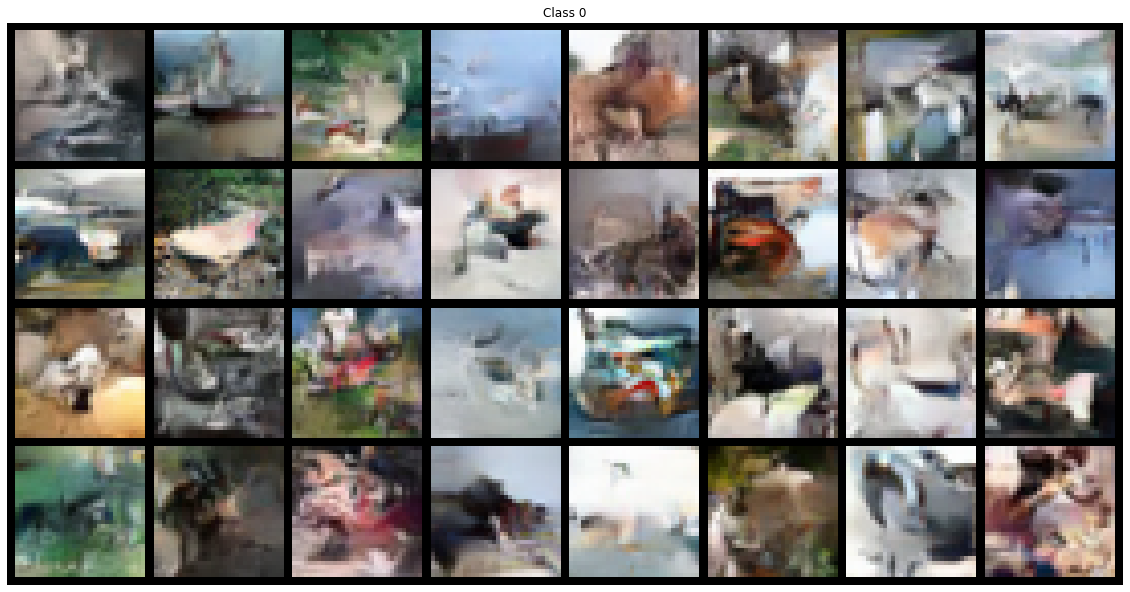

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


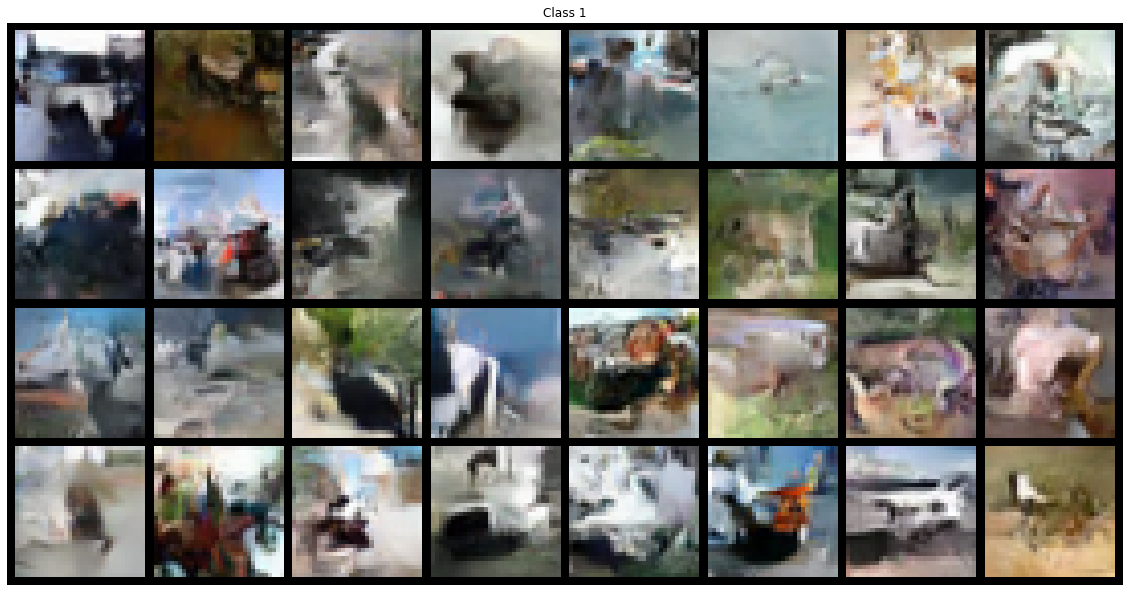

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


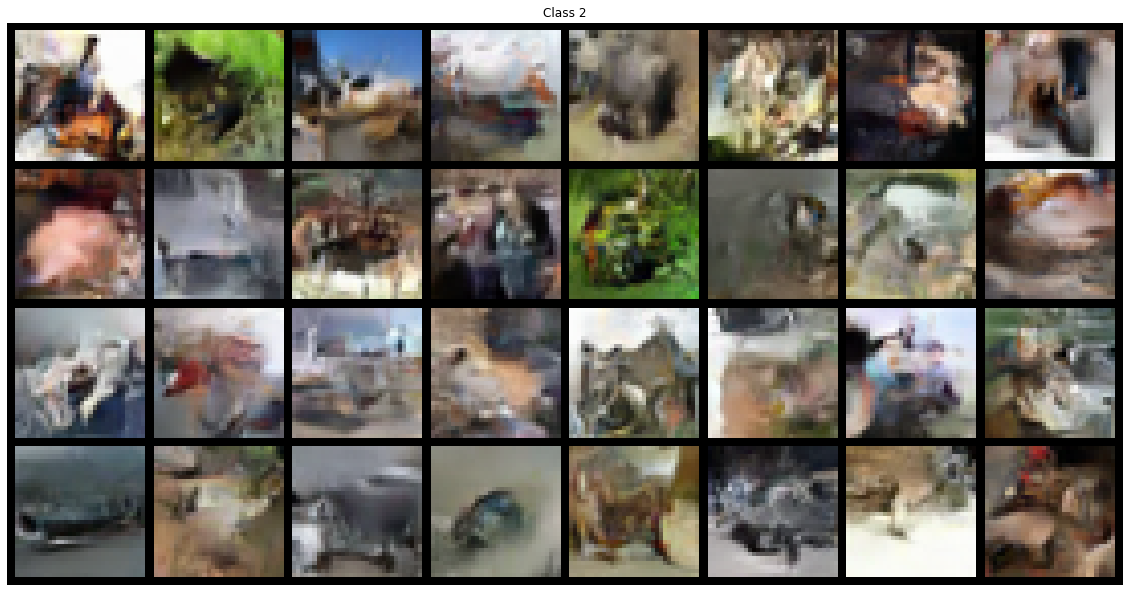

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


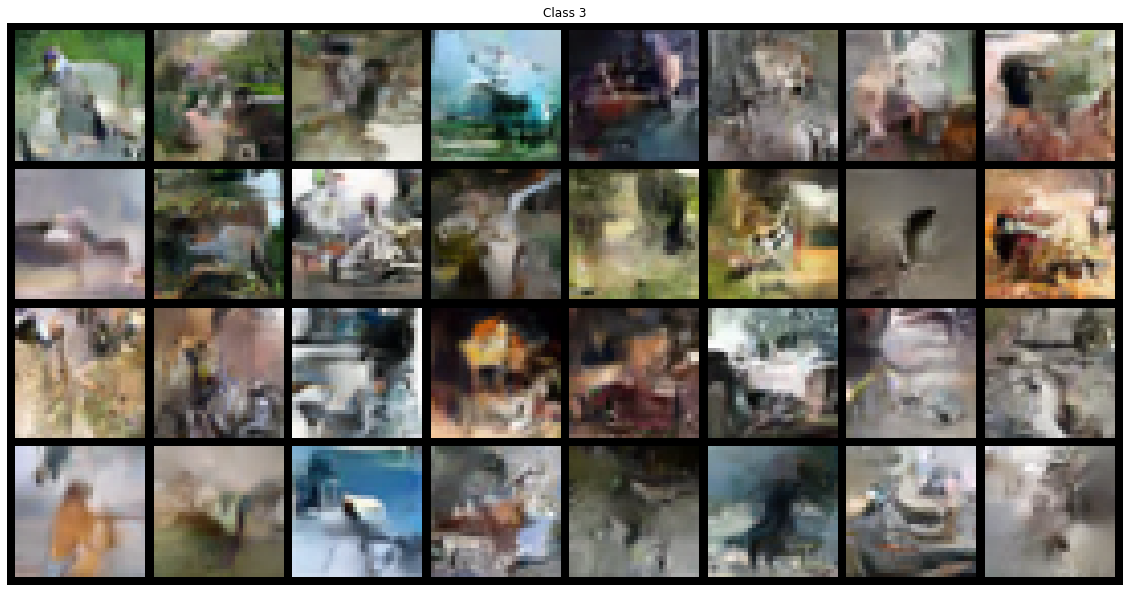

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


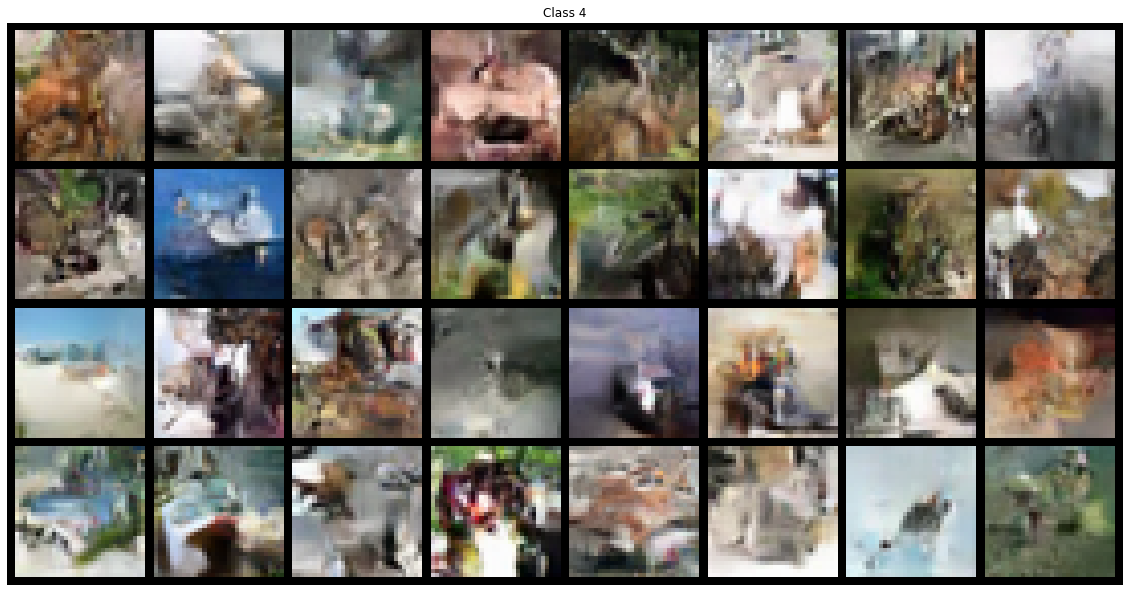

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


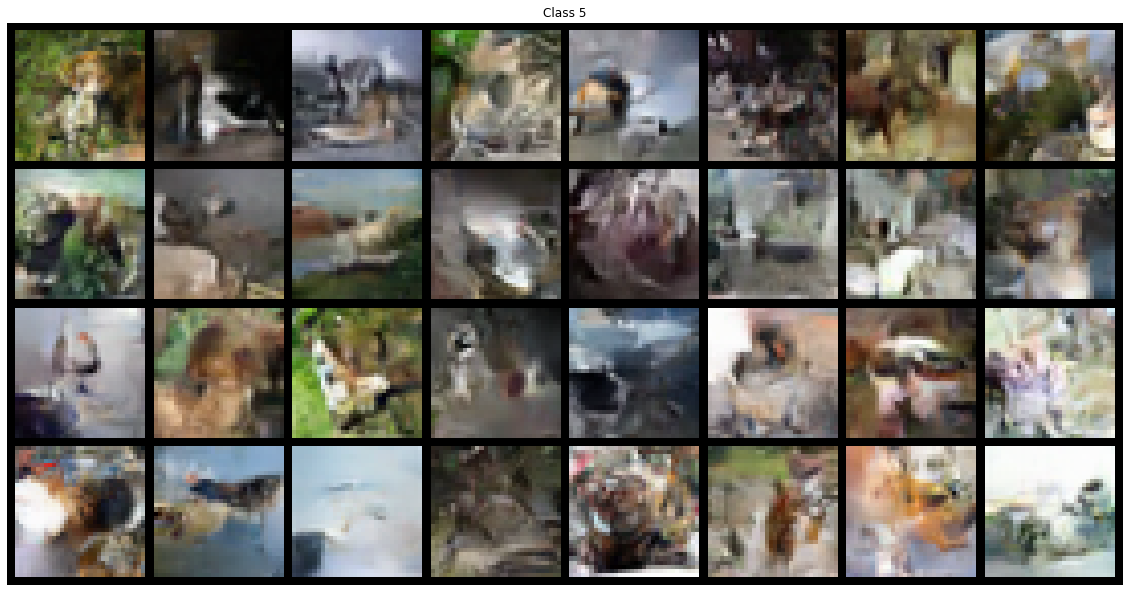

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


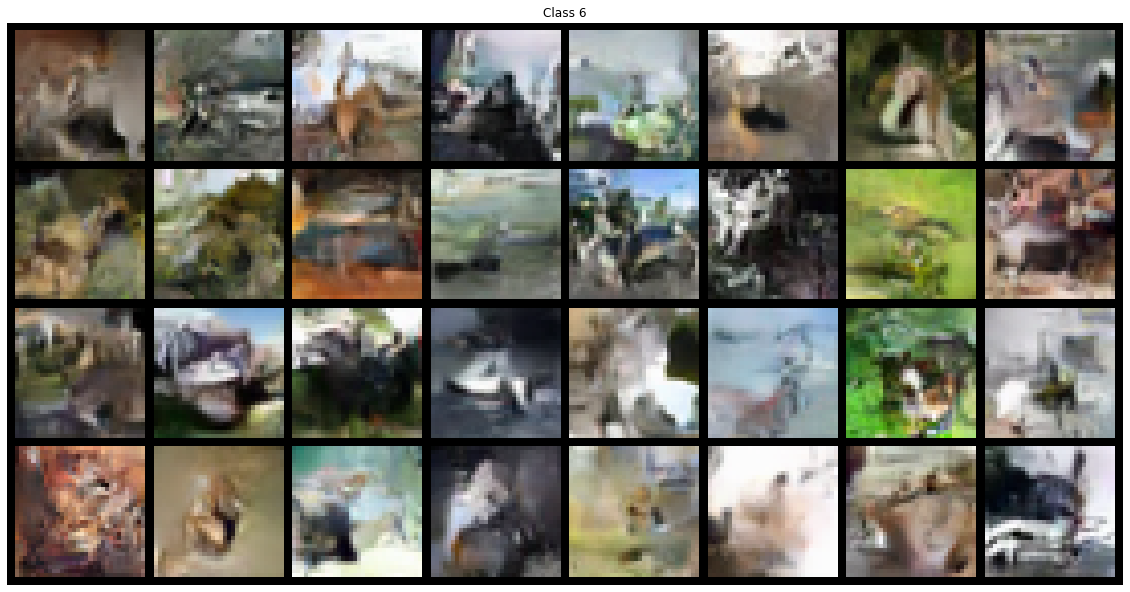

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


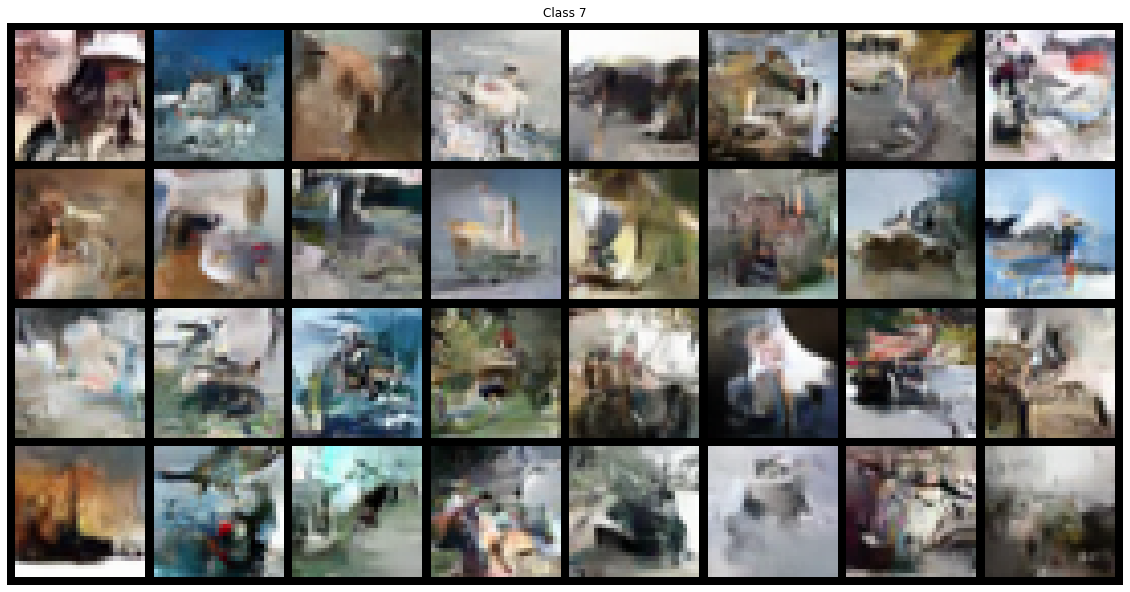

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


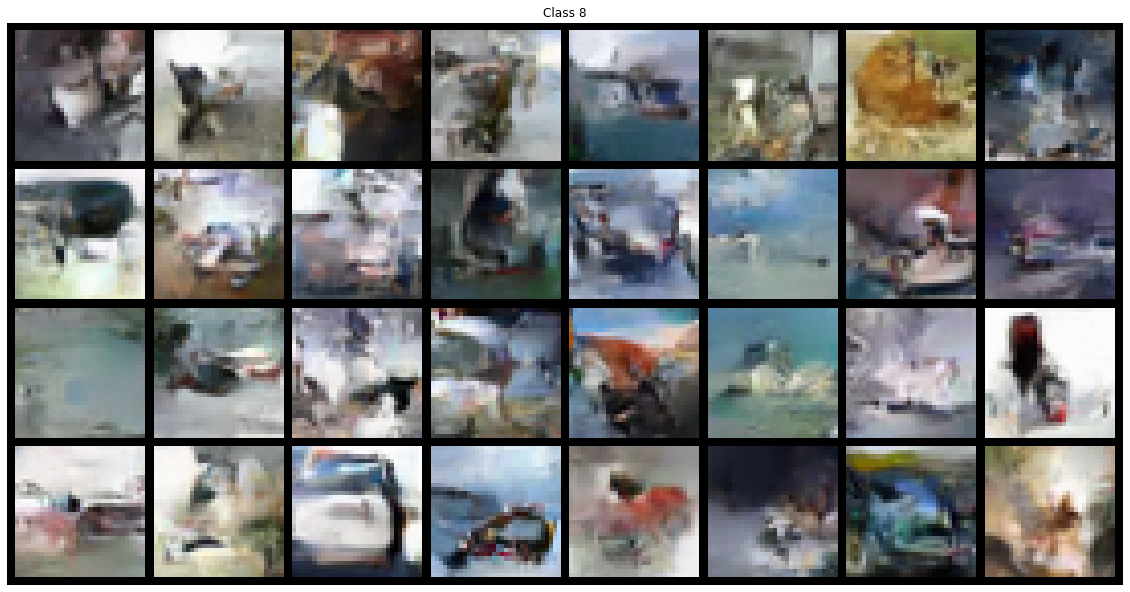

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


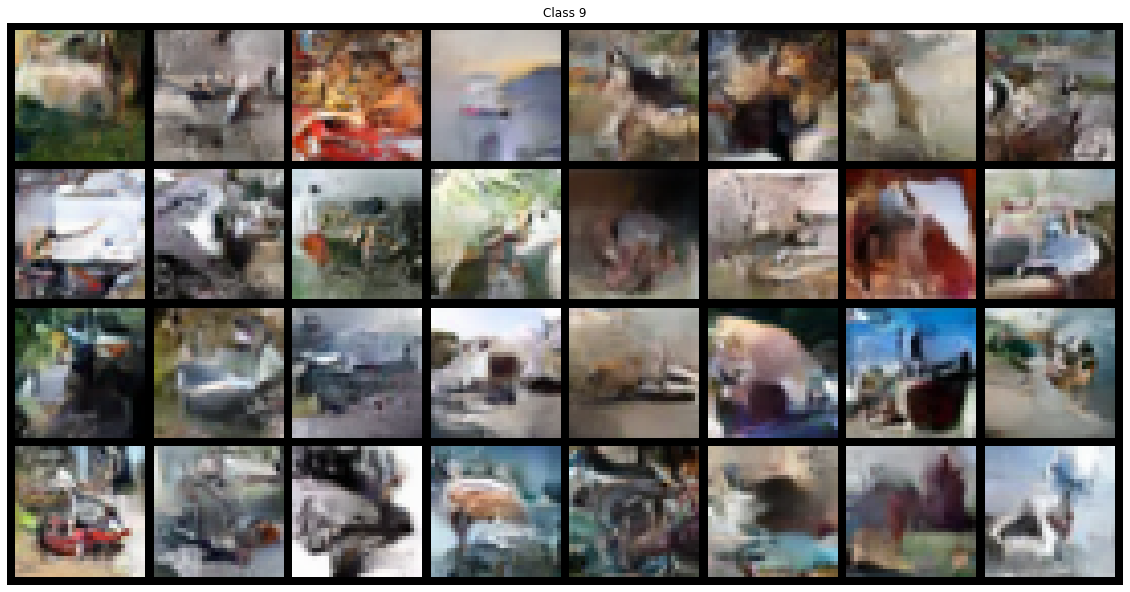

In [14]:
model.load_state_dict(torch.load('cond_cifar_best_model.pth'))
model.latent_distribution.loc_model.load_state_dict(torch.load('cond_cifar_best_model_smem.pth'))
model.latent_distribution.loc_model.eval()
model.eval()
;

def adjust_scaling_factors(glow_model, temperature):
    def adjust_scaling_factor(layer):
        if isinstance(layer, GlowBlockCouplingLayer):
            for sublayer in layer.children():
                if isinstance(sublayer, nn.ModuleList):
                    for item in sublayer:
                        if isinstance(item, AffineCouplingLayer):
                            cf = item.coupling_function
                            if isinstance(cf, GlowCouplingFunction):
                                cf.scaling_factor = temperature
                elif isinstance(sublayer, AffineCouplingLayer):
                    cf = sublayer.coupling_function
                    if isinstance(cf, GlowCouplingFunction):
                        cf.scaling_factor = temperature
        elif hasattr(layer, 'children'):
            for sublayer in layer.children():
                adjust_scaling_factor(sublayer)

    for layer in glow_model.layers:
        adjust_scaling_factor(layer)

with torch.no_grad():
    batch_val_losses = []
    for idx, (val_samples, classes) in enumerate(val_loader):
        print(f"{idx+1}/{len(val_loader)}", end='\r')
        val_samples = val_samples.to(device)
        classes = classes.to(device)
        val_loss = -torch.mean(model.log_prob(val_samples, classes))
        batch_val_losses.append(val_loss.item())
    avg_val_loss = np.mean(batch_val_losses)
    
    print("Avg val loss : ", avg_val_loss)
    adjust_scaling_factors(model, 1)
    for i in range(10):
        c = torch.tensor([i for _ in range(32)]).to(device)
        samples = model.sample(32, c)
        plt.figure(figsize=(20, 20))
        plt.title(f"Class {i}")
        show_images(samples)
        plt.show()